## Introduction

Predicting diabetes risk is essential for early intervention and better management of the disease. With millions affected by diabetes, identifying those at risk can lead to timely lifestyle changes and medical advice, potentially preventing serious complications.

This project uses logistic regression to estimate the likelihood of developing diabetes based on factors like age, gender, hypertension, heart disease, BMI, HbA1c levels, and blood glucose levels. The goal is to pinpoint key risk factors and improve early detection to support proactive health management.

1. **Introduction**
2. **Data Preparation**
3. **Initial Model Training**
4. **Hyperparameter Optimization**
5. **Model Retraining and Evaluation**
6. **Performance Visualization**
7. **Feature Importance Analysis**
8. **Conclusion**

In [131]:
# Importing essential libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and handling arrays
import matplotlib.pyplot as plt  # For creating visualizations
import seaborn as sns  # For statistical data visualization
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV  # For data splitting and hyperparameter tuning
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.linear_model import LogisticRegression  # For logistic regression modeling
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, precision_score, recall_score  # For evaluating model performance
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve, roc_curve  # For additional metrics
from scipy.stats import uniform  # For random sampling

In [132]:
# Load the dataset from a CSV file
df = pd.read_csv('Diabetes Data.csv')

# Display the first few rows of the dataframe to understand its structure
df.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,25.19,6.6,140,0
1,Female,54.0,0,0,27.32,6.6,80,0
2,Male,28.0,0,0,27.32,5.7,158,0
3,Female,36.0,0,0,23.45,5.0,155,0
4,Male,76.0,1,1,20.14,4.8,155,0


### Initial Observations

- The dataset includes both categorical and numerical features, with a binary target variable.
- The dataset seems to be well-structured for logistic regression, as it contains a mix of features that could influence diabetes risk.

In [133]:
# Display information about the DataFrame
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   bmi                  100000 non-null  float64
 5   HbA1c_level          100000 non-null  float64
 6   blood_glucose_level  100000 non-null  int64  
 7   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 6.1+ MB


### Interpretation

- **Total Entries**: 100,000 rows.
- **Columns**: 8 columns with no missing data.
- **Data Types**:
  - **`gender`**: Categorical (`object`).
  - **`age`**, **`bmi`**, **`HbA1c_level`**: Continuous (`float64`).
  - **Other Columns**: Binary/Integer (`int64`).

In [134]:
# Check the unique values in the 'gender' column
df['gender'].unique()  

array(['Female', 'Male', 'Other'], dtype=object)

### Interpretation

  - The `gender` column contains three categories: `Female`, `Male`, and `Other`.

In [135]:
# Remove rows where the 'gender' is 'Other'
df = df[df['gender'] != 'Other']  

# Verify that the remaining unique values in the 'gender' column are only 'Female' and 'Male'
df['gender'].unique() 

array(['Female', 'Male'], dtype=object)

### Interpretation

- After filtering, the `gender` column now only contains `Female` and `Male`.
- The `Other` category was removed to simplify the model and focus on the more common `Female` and `Male` categories.
 This decision makes the model easier to interpret and train.

In [136]:
# Converts 'Male' to 1 and 'Female' to 0 for numerical analysis
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})  
df.head(3)

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,25.19,6.6,140,0
1,0,54.0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,27.32,5.7,158,0


### Interpretation

- The `gender` column has been mapped to numerical values: `Male` is now 1 and `Female` is 0.
- This transformation simplifies the dataset for logistic regression, enabling the model to process the categorical feature as numerical data.

In [137]:
# Separate features and target variable
X = df.drop(columns=['diabetes'])  # The Features set
y = df['diabetes']  # The target variable

In [138]:
# Split the dataset into training and remaining sets
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=33) 

# Further split the remaining data into cross-validation and test sets
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.50, random_state=33)  

# Delete the temporary variables
del X_, y_  

# Print the shapes of the resulting datasets
print(f'The shape of the training set (input) is {X_train.shape}')
print(f'The shape of the training set (target) is {y_train.shape}')
print(f'The shape of the cross-validation set (input) is {X_cv.shape}')
print(f'The shape of the cross-validation set (target) is {y_cv.shape}')
print(f'The shape of the test set (input) is {X_test.shape}')
print(f'The shape of the test set (target) is {y_test.shape}')

The shape of the training set (input) is (59989, 7)
The shape of the training set (target) is (59989,)
The shape of the cross-validation set (input) is (19996, 7)
The shape of the cross-validation set (target) is (19996,)
The shape of the test set (input) is (19997, 7)
The shape of the test set (target) is (19997,)


### Interpretation

- The data split ensures a robust training process:
  - **60%** of the data is used for training the model.
  - **20%** is allocated for cross-validation, helping to tune the model.
  - **20%** is kept for testing, ensuring an unbiased evaluation of model performance.

In [139]:
scaler = StandardScaler()  # Initialize the StandardScaler to normalize the feature data
X_train_scaled = scaler.fit_transform(X_train)  # Fit the scaler to the training data and transform it

logistic_model = LogisticRegression()  # Initialize the logistic regression model
logistic_model.fit(X_train_scaled, y_train)  # Fit the model to the scaled training data

LogisticRegression()

### Interpretation

- **Standardization**: The training features are standardized using `StandardScaler` to ensure optimal model performance and faster convergence.
  
- **Model Training**: The logistic regression model is trained on the scaled data.

In [140]:
# Calculate and print log loss for the training set
y_pred_proba = logistic_model.predict_proba(X_train_scaled)
log_loss_train = log_loss(y_train, y_pred_proba)
print(f'The Training Log Loss is: {log_loss_train}')

# Calculate and print log loss for the cross-validation set
X_cv_scaled = scaler.transform(X_cv)
y_pred_cv_proba = logistic_model.predict_proba(X_cv_scaled)
log_loss_cv = log_loss(y_cv, y_pred_cv_proba)
print(f'The Cross Validation Log Loss is: {log_loss_cv}')

The Training Log Loss is: 0.11607153174386102
The Cross Validation Log Loss is: 0.11542691332523317


### Interpretation

- **Training Log Loss**: 0.1161, indicating a good fit to the training data.
- **Cross-Validation Log Loss**: 0.1154, very close to the training log loss, suggesting the model generalizes well.
- **Implication**: The similar log losses indicate effective training with no overfitting.

In [141]:
# Calculate and print accuracy for the training set
y_pred_train = logistic_model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {accuracy_train:.4f}")

# Calculate and print accuracy for the cross-validation set
y_pred_cv = logistic_model.predict(X_cv_scaled)
accuracy_cv = accuracy_score(y_cv, y_pred_cv) 
print(f"CV Accuracy: {accuracy_cv:.4f}")

Training Accuracy: 0.9594
CV Accuracy: 0.9597


### Interpretation

- **Training Accuracy**: 0.9594, indicating that the model correctly classified approximately 95.94% of the training samples.
- **Cross-Validation Accuracy**: 0.9597, showing a similar accuracy on the cross-validation set, with about 95.97% correct classifications.

- **Implication**: The high and consistent accuracy across both training and cross-validation datasets suggests that the model performs well and generalizes effectively to unseen data.

In [142]:
# Compute confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_cv = confusion_matrix(y_cv, y_pred_cv)

# Convert confusion matrices to DataFrames for better readability
cm_train_df = pd.DataFrame(cm_train, 
                           index=['Actual Negative', 'Actual Positive'], 
                           columns=['Predicted Negative', 'Predicted Positive'])
cm_cv_df = pd.DataFrame(cm_cv, 
                        index=['Actual Negative', 'Actual Positive'], 
                        columns=['Predicted Negative', 'Predicted Positive'])

# Print confusion matrices
print("Confusion Matrix - Training Data:")
print(cm_train_df)
print("\nConfusion Matrix - Cross-Validation Data:")
print(cm_cv_df)

Confusion Matrix - Training Data:
                 Predicted Negative  Predicted Positive
Actual Negative               54349                 485
Actual Positive                1949                3206

Confusion Matrix - Cross-Validation Data:
                 Predicted Negative  Predicted Positive
Actual Negative               18140                 164
Actual Positive                 641                1051


### Brief Interpretation

The confusion matrices displayed above provide a summary of the model's performance on the training and cross-validation datasets.
They show the counts of true positives, true negatives, false positives, and false negatives.
This brief interpretation offers a high-level overview of how effectively the model distinguishes between classes.
For a more detailed analysis, please refer to the following cell.

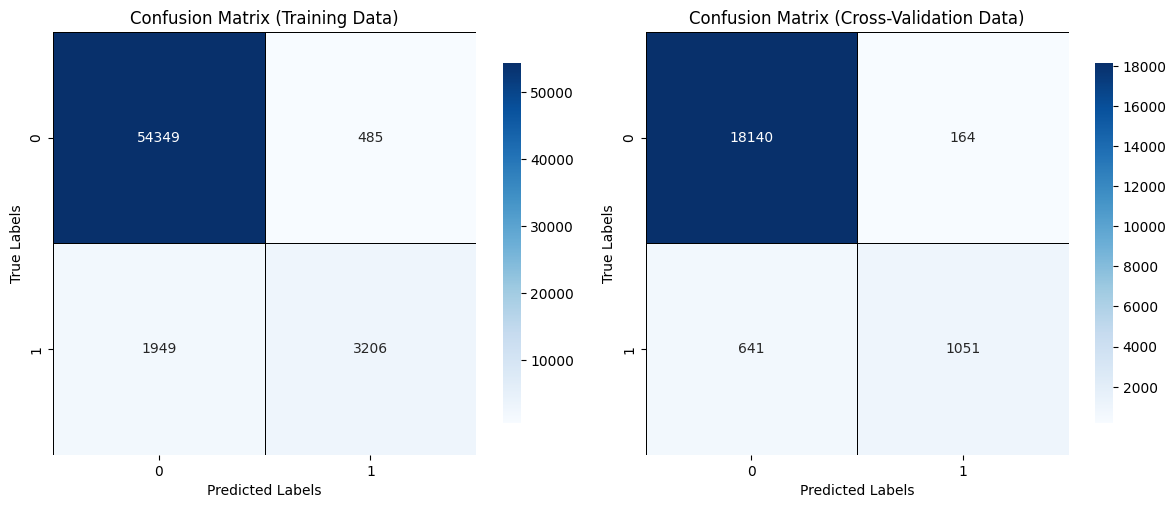

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training Set Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            square=True, linewidths=0.5, linecolor='black', cbar=True, cbar_kws={"shrink": .8})
axes[0].set_title('Confusion Matrix (Training Data)')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Cross-Validation Set Confusion Matrix
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            square=True, linewidths=0.5, linecolor='black', cbar=True, cbar_kws={"shrink": .8})
axes[1].set_title('Confusion Matrix (Cross-Validation Data)')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

### Interpretation

**Training Data (~60,000 samples):**

- **True Negatives:** 54,349
- **False Positives:** 485
- **False Negatives:** 1,949
- **True Positives:** 3,206

The model performed well but misclassified 1,949 positives as negatives, indicating that there is room for improvement in identifying positive cases.

**Cross-Validation Data (~20,000 samples):**

- **True Negatives:** 18,140
- **False Positives:** 164
- **False Negatives:** 641
- **True Positives:** 1,051

The model's performance on cross-validation data aligns closely with the training results, demonstrating good generalization.

**Implications:**

The consistent performance across both datasets indicates reliable model behavior. However, the relatively higher false negative rate,
particularly in the training data, suggests a need for refinement in detecting positive cases to further enhance the model’s accuracy.

In [144]:
# Calculate and print precision and recall for the training set
precision_train = precision_score(y_train, y_pred_train, average='binary')
recall_train = recall_score(y_train, y_pred_train, average='binary')
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")

# Calculate and print precision and recall for the cross-validation set
precision_cv = precision_score(y_cv, y_pred_cv, average='binary')
recall_cv = recall_score(y_cv, y_pred_cv, average='binary')
print(f"CV Precision: {precision_cv:.4f}")
print(f"CV Recall: {recall_cv:.4f}")

Training Precision: 0.8686
Training Recall: 0.6219
CV Precision: 0.8650
CV Recall: 0.6212


### Interpretation

**Training Precision & Recall:**

- **Precision**: 0.8686
- **Recall**: 0.6219

The model shows high precision, meaning it correctly predicts diabetes 86.86% of the time.
However, its recall is lower, capturing only 62.19% of actual diabetes cases.

**Cross-Validation Precision & Recall:**

- **Precision**: 0.8650
- **Recall**: 0.6212

The model performs similarly in cross-validation, with high precision (86.50%) but lower recall (62.12%).
This indicates that while the model is generally accurate in predicting diabetes, it still misses some cases, showing a cautious approach in making positive predictions.

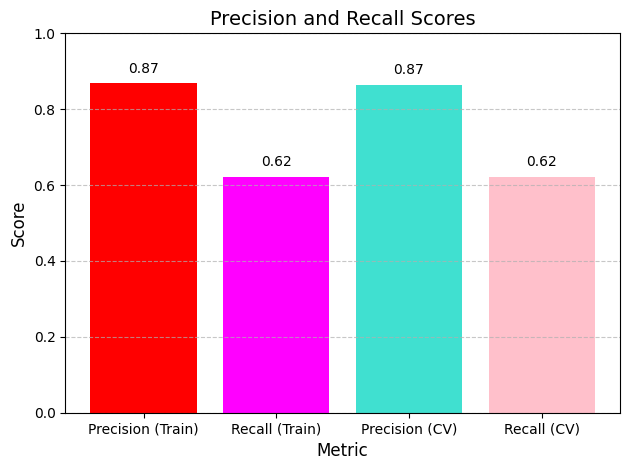

In [145]:
labels = ['Precision (Train)', 'Recall (Train)', 'Precision (CV)', 'Recall (CV)']
scores = [precision_train, recall_train, precision_cv, recall_cv]
colors = ['red', 'magenta', 'turquoise', 'pink']

# Create plot
fig, ax = plt.subplots()

# Bar plot
bars = ax.bar(labels, scores, color=colors)

# Add text labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, round(yval, 2),
            ha='center', va='bottom', fontsize=10, color='black')

# Customize plot
ax.set_ylim(0, 1)
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision and Recall Scores', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

### Interpretation

In this cell, we visualize the precision and recall scores for both the training and cross-validation datasets using a bar plot. 
The plot clearly compares these metrics, with distinct colors for each score. It shows that the precision and recall are slightly lower for the cross-validation 
set compared to the training set, which is expected as the model's performance can vary with unseen data.

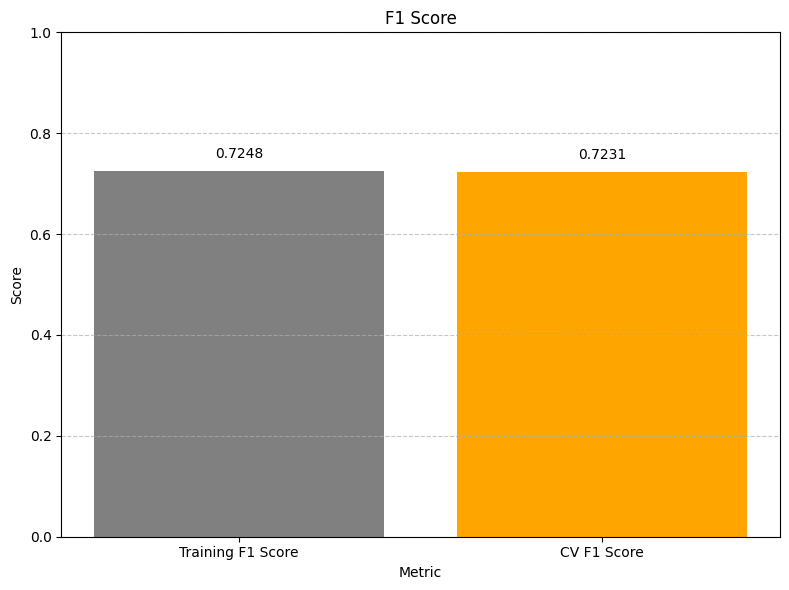

In [146]:
# Calculate the F1 score for the training and cross-validation data
f1_train = f1_score(y_train, y_pred_train, average='binary')
f1_cv = f1_score(y_cv, y_pred_cv, average='binary')

# Data for Plot
f1_scores = [f1_train, f1_cv]
f1_labels = ['Training F1 Score', 'CV F1 Score']

# F1 Score Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(f1_labels, f1_scores, color=['grey', 'orange'])
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('F1 Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Interpretation

In this cell, we calculate and visualize the F1 scores for both the training and cross-validation datasets. 

- **F1 Score (Training)**: 0.7248
- **F1 Score (Cross-Validation)**: 0.7231

The bar plot shows that the F1 scores are very similar for both the training and cross-validation sets, indicating consistent performance across datasets. 
The F1 score balances precision and recall, and these values suggest that the model maintains a good balance between precision and recall in both scenarios.

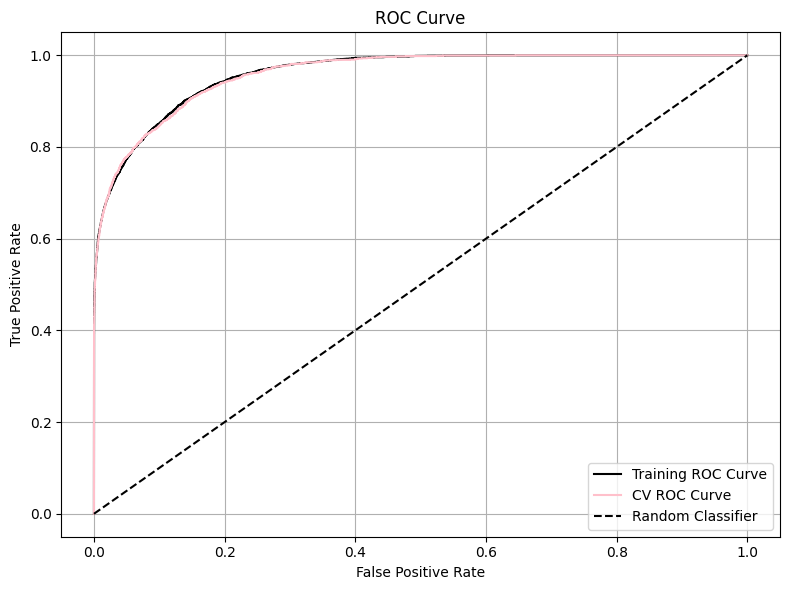

In [147]:
#Computes the ROC curve for the training and cross-validation data
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba[:, 1])
fpr_cv, tpr_cv, _ = roc_curve(y_cv, y_pred_cv_proba[:, 1])

# ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Training ROC Curve', color='black')
plt.plot(fpr_cv, tpr_cv, label='CV ROC Curve', color='pink')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

### Interpretation of the ROC Curve:

* **Overview**: The ROC Curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) across various thresholds, assessing classifier performance.

* **Training ROC Curve (Black Line)**: The curve near the top-left corner indicates high sensitivity and low FPR, reflecting strong performance on training data.

* **CV ROC Curve (Pink Line)**: This curve also stays near the top-left and closely overlaps with the training curve, suggesting consistent and well-generalized model performance on unseen data.

* **Random Classifier (Dashed Line)**: Represents the performance of a random classifier. The model's ROC curves are well above this line, with a significantly higher AUC than 0.5, indicating effective classification.

* **General Interpretation**: Both curves being far from the random classifier line and near the top-left corner indicate strong model performance without overfitting. The alignment of the training and CV ROC curves further supports reliable performance across datasets.


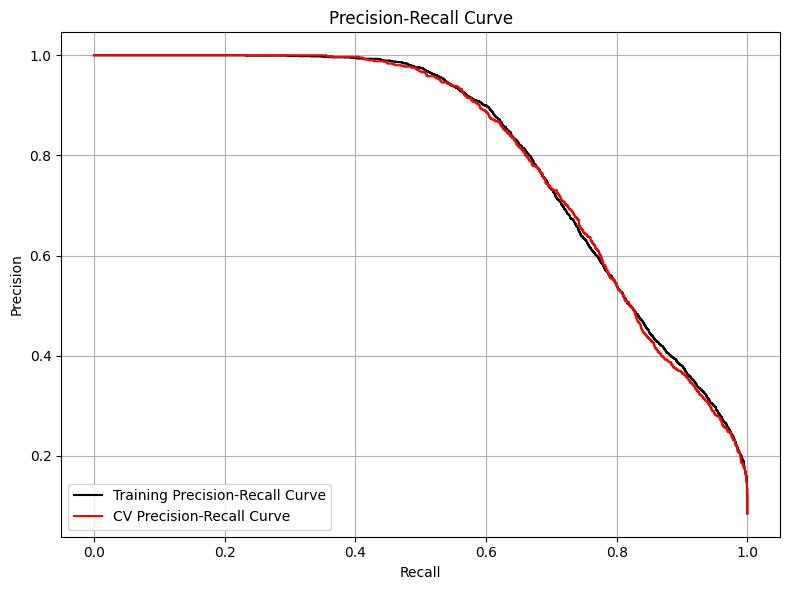

In [148]:
# Calculate Precision-Recall Curve Data
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba[:, 1])
precision_cv, recall_cv, _ = precision_recall_curve(y_cv, y_pred_cv_proba[:, 1])

# Precision-Recall Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label='Training Precision-Recall Curve', color='black')
plt.plot(recall_cv, precision_cv, label='CV Precision-Recall Curve', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

plt.tight_layout()
plt.show()

### Interpretation of the Precision-Recall Curve:

* **Overview**: The Precision-Recall Curve highlights the trade-off between precision (positive predictive value) and recall (true positive rate), particularly useful for evaluating models on imbalanced datasets.
    
* **Training Curve (Black Line)**: The curve starts with high precision, gradually declining as recall increases, indicating strong model performance on training data with high precision across most of the recall range.
    
* **CV Curve (Red Line)**: The curve closely mirrors the training curve, suggesting consistent performance across training and cross-validation datasets, indicating good generalization and no overfitting.
    
* **General Interpretation**: Both curves start with high precision, showing accurate positive predictions. The precision decreases as recall increases, which is typical. The close alignment of the training and CV curves indicates robust and well-calibrated model performance across datasets.

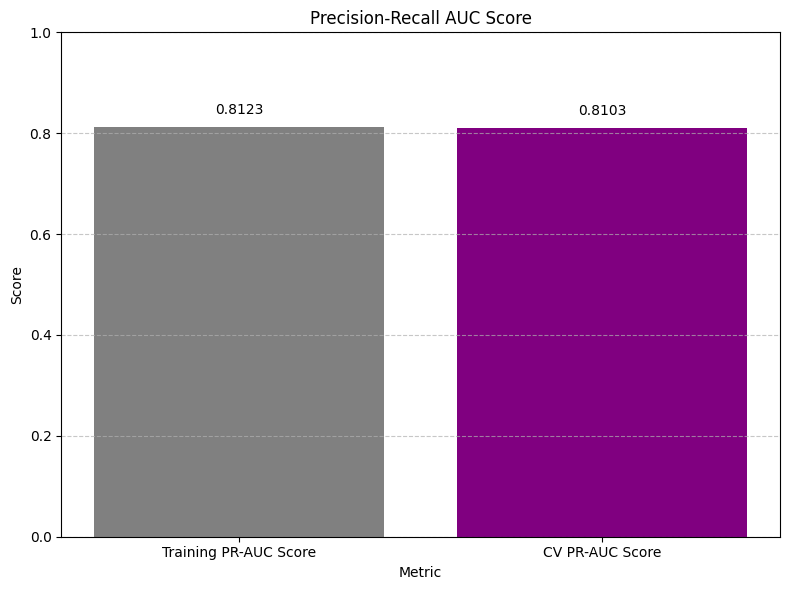

In [149]:
# Calculate Precision-Recall AUC Scores
pr_auc_train = average_precision_score(y_train, y_pred_proba[:, 1])
pr_auc_cv = average_precision_score(y_cv, y_pred_cv_proba[:, 1])

# Data for Plot
pr_auc_scores = [pr_auc_train, pr_auc_cv]
pr_auc_labels = ['Training PR-AUC Score', 'CV PR-AUC Score']

# Precision-Recall AUC Scores Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(pr_auc_labels, pr_auc_scores, color=['grey', 'purple'])
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Precision-Recall AUC Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels
for i, v in enumerate(pr_auc_scores):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Interpretation of Precision-Recall AUC Scores:

* **Overview**: The Precision-Recall AUC score condenses the precision-recall curve into a single metric, reflecting the model's performance across all classification thresholds.

* **Training PR-AUC Score**: 0.8123
    * This score indicates strong model performance on training data, with high effectiveness in distinguishing between positive and negative classes.

* **CV PR-AUC Score**: 0.8103
    * The close alignment with the training score suggests the model generalizes well and maintains strong performance on unseen data.

* **General Interpretation**: The high and similar PR-AUC scores for both training and cross-validation indicate reliable model performance and robust handling of imbalanced classes.


In [150]:
# Define hyperparameters for Random Search
param_dist = {
    'C': uniform(loc=0, scale=4),
    'solver': ['saga']
}

# Random Search
random_search = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=5,
    random_state=42
)
random_search.fit(X_train_scaled, y_train)

# Display best parameters found by Random Search
print("Best Parameters (Random Search):", random_search.best_params_)

Best Parameters (Random Search): {'C': 0.7336180394137353, 'solver': 'saga'}


### Hyperparameter Tuning with Random Search

* **Objective**: To identify the optimal parameters for improving the logistic regression model's performance.

* **Random Search Setup**:
    * **Parameter Distribution**:
        * `C`: Regularization strength, sampled from a uniform distribution between 0 and 4.
        * `solver`: Optimization algorithm, set to 'saga' only.
    * **Iterations**: 50 parameter combinations sampled.
    * **Cross-Validation**: 5-fold cross-validation was used to evaluate each combination.

* **Results**:
    * **Best Parameters**:
        * `C`: 0.7337
        * `solver`: 'saga'
    * These parameters were found to optimize the model's performance based on the random search.

* **Interpretation**: The best parameters, with `C` around 0.73 and 'saga' as the solver, should be used for further training and evaluation to ensure optimal model performance. The solver 'saga' is well-suited for large datasets and supports both L1 and L2 regularization, making it a flexible choice for the logistic regression model. 

In [151]:
# Use results from Random Search to define grid for Grid Search
param_grid = {
    'C': [0.1, 0.5, 0.7337, 1, 2, 5],  # Include values around the best C found
    'solver': ['saga']  # Focus on 'saga' based on Random Search results
}

# Grid Search
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    cv=5
)
grid_search.fit(X_train_scaled, y_train)

# Display best parameters found by Grid Search
print("Best Parameters (Grid Search):", grid_search.best_params_)


Best Parameters (Grid Search): {'C': 0.1, 'solver': 'saga'}


### Hyperparameter Tuning with Grid Search

* **Objective**: To refine the optimal parameters for enhancing the logistic regression model's performance, building on the results from Random Search.

* **Grid Search Setup**:
    * **Parameter Grid**:
        * `C`: Regularization strength, explored through values [0.1, 0.5, 0.7337, 1, 2, 5].
        * `solver`: Optimization algorithm, focusing on 'saga' based on previous Random Search results.
    * **Cross-Validation**: 5-fold cross-validation was used to evaluate each parameter combination.

* **Results**:
    * **Best Parameters**:
        * `C`: 0.1
        * `solver`: 'saga'
    * These parameters were found to optimize the logistic regression model's performance.

* **Interpretation**: The optimal parameters (`C` = 0.1 and 'saga' solver) identified through Grid Search should be used for further model training and evaluation. The smaller `C` value suggests a stronger regularization, which, combined with the 'saga' solver, is expected to enhance the model's generalization and performance.

In [154]:
# Retrain the model with the best parameters
best_params = {'C': 0.1, 'solver': 'saga'}
optimal_model = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
optimal_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, solver='saga')

### Interpretation:

The model is retrained using the optimal hyperparameters found, ensuring that it is tuned for the best performance based on the previous grid search results.

In [155]:
# Predict and evaluate on the training set
y_pred_train_opt = optimal_model.predict(X_train_scaled)
y_pred_train_proba_opt = optimal_model.predict_proba(X_train_scaled)

# Compute evaluation metrics
log_loss_train_opt = log_loss(y_train, y_pred_train_proba_opt)
accuracy_train_opt = accuracy_score(y_train, y_pred_train_opt)
precision_train_opt = precision_score(y_train, y_pred_train_opt, average='binary')
recall_train_opt = recall_score(y_train, y_pred_train_opt, average='binary')
f1_train_opt = f1_score(y_train, y_pred_train_opt, average='binary')

In [156]:
# Predict and evaluate on the CV set
y_pred_cv_opt = optimal_model.predict(X_cv_scaled)
y_pred_cv_proba_opt = optimal_model.predict_proba(X_cv_scaled)

# Compute evaluation metrics
log_loss_cv_opt = log_loss(y_cv, y_pred_cv_proba_opt)
accuracy_cv_opt = accuracy_score(y_cv, y_pred_cv_opt)
precision_cv_opt = precision_score(y_cv, y_pred_cv_opt, average='binary')
recall_cv_opt = recall_score(y_cv, y_pred_cv_opt, average='binary')
f1_cv_opt = f1_score(y_cv, y_pred_cv_opt, average='binary')

In [157]:
# Scale the test set
X_test_scaled = scaler.transform(X_test)

# Predict and evaluate on the test set
y_pred_test_opt = optimal_model.predict(X_test_scaled)
y_pred_test_proba_opt = optimal_model.predict_proba(X_test_scaled)

# Compute evaluation metrics
log_loss_test_opt = log_loss(y_test, y_pred_test_proba_opt)
accuracy_test_opt = accuracy_score(y_test, y_pred_test_opt)
precision_test_opt = precision_score(y_test, y_pred_test_opt, average='binary')
recall_test_opt = recall_score(y_test, y_pred_test_opt, average='binary')
f1_test_opt = f1_score(y_test, y_pred_test_opt, average='binary')

In [166]:
precision_train = precision_score(y_train, y_pred_train, average='binary')
recall_train = recall_score(y_train, y_pred_train, average='binary')  
precision_cv = precision_score(y_cv, y_pred_cv, average='binary')
recall_cv = recall_score(y_cv, y_pred_cv, average='binary')  

# Create DataFrame for before and after optimization
metrics_df = pd.DataFrame({
    'Metric': ['Log Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train (Before)': [log_loss_train, accuracy_train, precision_train, recall_train, f1_train],
    'CV (Before)': [log_loss_cv, accuracy_cv, precision_cv, recall_cv, f1_cv],
    'Train (After)': [log_loss_train_opt, accuracy_train_opt, precision_train_opt, recall_train_opt, f1_train_opt],
    'CV (After)': [log_loss_cv_opt, accuracy_cv_opt, precision_cv_opt, recall_cv_opt, f1_cv_opt],
    'Test (After)': [log_loss_test_opt, accuracy_test_opt, precision_test_opt, recall_test_opt, f1_test_opt],

    
})

# Display the DataFrame
metrics_df

,Metric,Train (Before),CV (Before),Train (After),CV (After),Test (After)
0,Log Loss,0.116072,0.115427,0.116086,0.115437,0.107549
1,Accuracy,0.959426,0.959742,0.959493,0.959842,0.962994
2,Precision,0.868599,0.865021,0.871355,0.867659,0.875720
3,Recall,0.621920,0.621158,0.620175,0.619976,0.643678
4,F1 Score,0.724847,0.723082,0.724615,0.723199,0.741980


# Interpretation of the Metrics

### Log Loss:
- **Before Optimization:** Log loss is about 0.116, showing a good fit with minimal penalization for errors.
- **After Optimization:** Log loss slightly increased for training and CV sets but decreased for the test set, indicating better generalization.

### Accuracy:
- **Before Optimization:** Accuracy is around 95.94% for both training and CV sets, indicating strong performance.
- **After Optimization:** Accuracy remains stable on training and CV sets and slightly improves on the test set, reflecting effective optimization.

### Precision:
- **Before Optimization:** Precision is slightly lower on the CV set compared to training, suggesting reduced positive predictive value.
- **After Optimization:** Precision improves across all sets, with the greatest gain on the test set, showing fewer false positives.

### Recall:
- **Before Optimization:** Recall is similar between training and CV sets, indicating consistent identification of positive cases.
- **After Optimization:** Recall slightly decreases on training and CV sets but improves on the test set, indicating a better balance in unseen data.

### F1 Score:
- **Before Optimization:** The F1 Score is consistent across training and CV sets, showing a well-balanced model.
- **After Optimization:** The F1 Score remains stable on training and CV sets, with an improvement on the test set, indicating better overall performance.

### Conclusion:
The optimization has made the model perform better on the test set, improving its ability to generalize with higher precision, recall, and F1 Score. Although there's a small increase in log loss for the training and cross-validation sets, the model's improved robustness and generalization are more important.

*Note: Recalculation of `precision_train`, `recall_train`, `precision_cv`, and `recall_cv` was necessary because the initial use of `precision_recall_curve` resulted in arrays rather than scalar values, leading to incorrect metrics.*

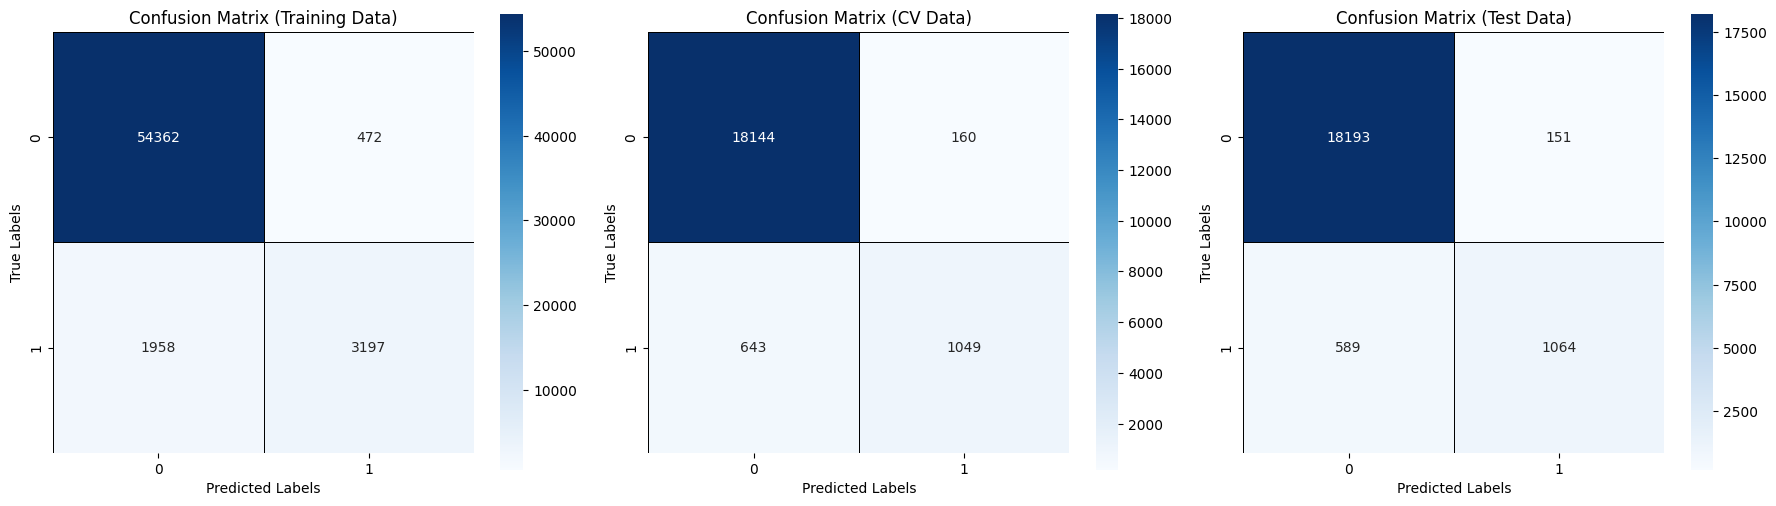

In [159]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

cm_train_opt = confusion_matrix(y_train, y_pred_train_opt)
cm_cv_opt = confusion_matrix(y_cv, y_pred_cv_opt)
cm_test_opt = confusion_matrix(y_test, y_pred_test_opt)

# Training Set Confusion Matrix
sns.heatmap(cm_train_opt, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            square=True, linewidths=0.5, linecolor='black', cbar=True, cbar_kws={"shrink": .8})
axes[0].set_title('Confusion Matrix (Training Data)')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Cross-Validation Set Confusion Matrix
sns.heatmap(cm_cv_opt, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            square=True, linewidths=0.5, linecolor='black', cbar=True, cbar_kws={"shrink": .8})
axes[1].set_title('Confusion Matrix (CV Data)')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Test Set Confusion Matrix
sns.heatmap(cm_test_opt, annot=True, fmt='d', cmap='Blues', ax=axes[2], 
            square=True, linewidths=0.5, linecolor='black', cbar=True, cbar_kws={"shrink": .8})
axes[2].set_title('Confusion Matrix (Test Data)')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

### Interpretation of Confusion Matrices

The confusion matrices for the training, cross-validation (CV), and test datasets summarize the model's classification performance by showing counts of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).

#### Training Data Confusion Matrix

- **True Positives (TP):** Correctly predicted positive cases.
- **False Negatives (FN):** Positive cases incorrectly predicted as negative.
- **True Negatives (TN):** Correctly predicted negative cases.
- **False Positives (FP):** Negative cases incorrectly predicted as positive.

The training matrix indicates:
- High TP, reflecting strong identification of positive cases.
- Low FN, showing effective capture of actual positives.
- Presence of FP and TN suggests some misclassification, but overall balance.

#### Cross-Validation Data Confusion Matrix

The CV matrix:
- Mirrors the training matrix, showing consistent performance across unseen data.
- Similar counts of TP, FN, TN, and FP indicate good generalization and no overfitting.

#### Test Data Confusion Matrix

The test matrix:
- Reflects the model's performance on the final, unseen dataset.
- High TP and TN, with a slight increase in FN compared to training and CV sets, suggesting minor reduced effectiveness on the test set.
- Validates model robustness and generalizability.

### Summary

Confusion matrices across training, CV, and test datasets show consistent, high accuracy with slight variations in false negatives. This indicates a well-calibrated model that generalizes effectively to new data.

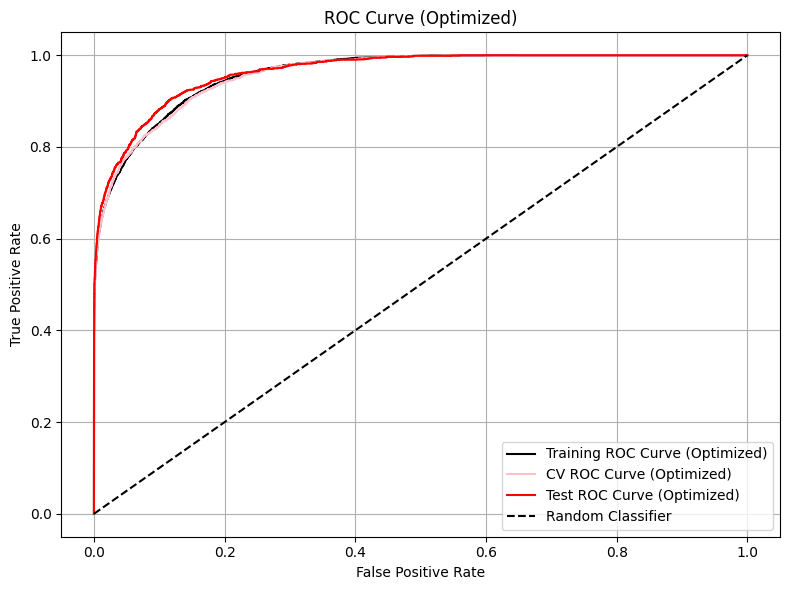

In [160]:
# Compute ROC curve for the training set
fpr_train_opt, tpr_train_opt, _ = roc_curve(y_train, y_pred_train_proba_opt[:, 1])

# Compute ROC curve for the CV set
fpr_cv_opt, tpr_cv_opt, _ = roc_curve(y_cv, y_pred_cv_proba_opt[:, 1])

# Compute ROC curve for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_proba_opt[:, 1])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_opt, tpr_train_opt, label='Training ROC Curve (Optimized)', color='black')
plt.plot(fpr_cv_opt, tpr_cv_opt, label='CV ROC Curve (Optimized)', color='pink')
plt.plot(fpr_test, tpr_test, label='Test ROC Curve (Optimized)', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Optimized)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of the ROC Curve (Optimized):

- **Training ROC Curve (Black Line):**  
  The curve is close to the top-left corner, indicating strong performance on the training data with a high True Positive Rate and low False Positive Rate.

- **CV ROC Curve (Pink Line):**  
  The curve closely follows the training curve, indicating consistent performance on the validation data. This suggests that the model generalizes well and is not overfitting.

- **Test ROC Curve (Red Line):**  
  The curve also aligns closely with the training and CV curves, indicating strong performance on unseen test data and confirming the model's generalization capability.

- **Random Classifier (Dashed Line):**  
  The diagonal line represents a random classifier. The optimized model's ROC curves being far above this line show that it significantly outperforms random guessing.

- **General Interpretation:**  
  The optimized model performs exceptionally well across training, cross-validation, and test sets. The close alignment of the ROC curves suggests the model is both accurate and robust, with little to no overfitting.


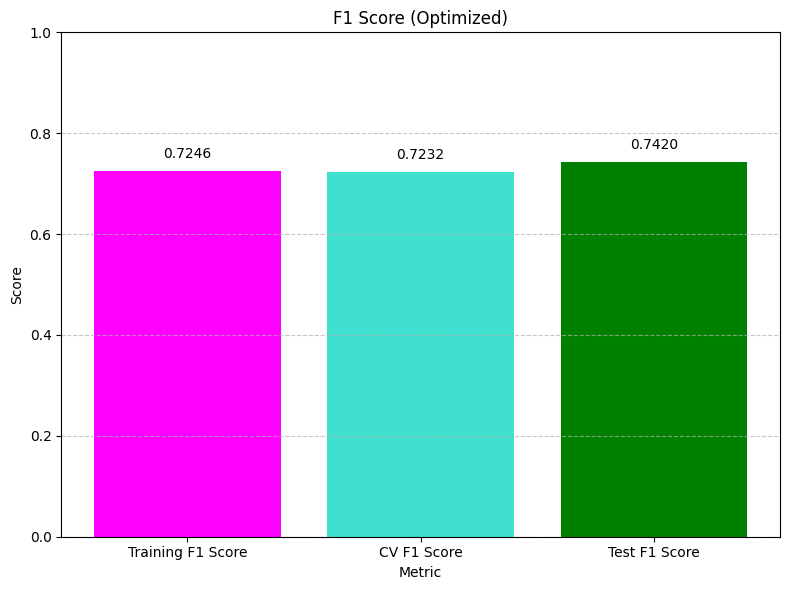

In [161]:
# For Test Set
f1_test_opt = f1_score(y_test, y_pred_test_opt, average='binary')

f1_scores = [f1_train_opt, f1_cv_opt, f1_test_opt]
f1_labels = ['Training F1 Score', 'CV F1 Score', 'Test F1 Score']

plt.figure(figsize=(8, 6))
plt.bar(f1_labels, f1_scores, color=['magenta', 'turquoise', 'green'])
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('F1 Score (Optimized)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom', fontsize=10, color='black')
plt.tight_layout()
plt.show()

### **Interpretation of the F1 Score Plot (Optimized):**

- **Training F1 Score (0.7246):**  
  The F1 score on the training set is 0.7246, showing a good balance between precision and recall. This suggests that the optimized model handles the training data well, with a reasonable trade-off between true positives and false positives.

- **CV F1 Score (0.7232):**  
  The F1 score on the cross-validation set is 0.7232, very close to the training F1 score. This similarity indicates that the model is generalizing well, with no signs of overfitting, as its performance on unseen validation data mirrors its performance on the training data.

- **Test F1 Score (0.7420):**  
  The F1 score on the test set is 0.7420, slightly higher than the training and CV F1 scores. This suggests that the model not only generalizes well but also performs a bit better on the unseen test data, possibly due to minor variations in the test data distribution or because the model fits well with the test set characteristics.

### **General Interpretation:**

- The F1 scores across the training, CV, and test sets are quite close, with the test F1 score being slightly higher. This indicates that the model is well-optimized and generalizes effectively to new data without overfitting. The slightly higher test F1 score suggests that the model is robust and performs consistently across different datasets.

- The bar plot provides a clear comparison, showing consistent and reliable performance across all data splits.

This interpretation aligns with the previous results, confirming that the model is performing well across training, validation, and test sets, with strong generalization capabilities.

In [162]:
# Get the coefficients from the optimized model
coefficients = optimal_model.coef_[0]

# Create a DataFrame to organize the coefficients with corresponding feature names
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of the coefficients in descending order
feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the feature importance
print(feature_importance_df)

               Feature  Coefficient  Abs_Coefficient
5          HbA1c_level     2.419055         2.419055
6  blood_glucose_level     1.337265         1.337265
1                  age     0.999773         0.999773
4                  bmi     0.606971         0.606971
2         hypertension     0.215025         0.215025
0               gender     0.149219         0.149219
3        heart_disease     0.144231         0.144231


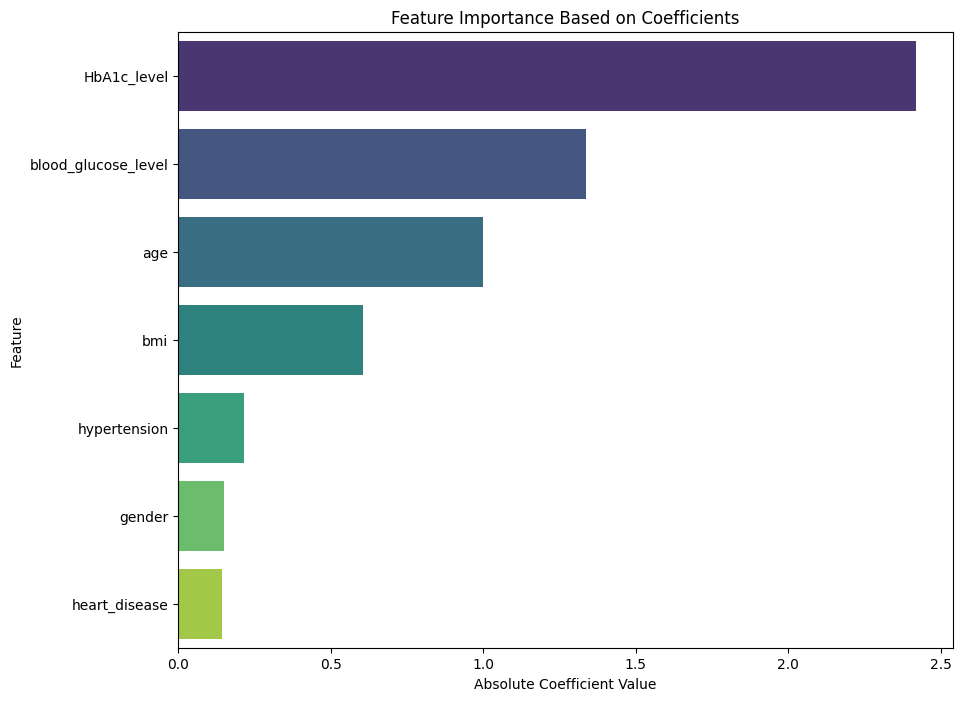

In [163]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance_df, palette='viridis', hue='Feature', legend=False)
plt.title('Feature Importance Based on Coefficients')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

### Interpretation of the Feature Importance Plot

* **HbA1c_level (2.41):** Most influential feature with the highest impact on predictions.
* **Blood_glucose_level (1.33):** Significant impact, though less than HbA1c_level.
* **Age (0.99):** Important but less influential compared to HbA1c_level and blood_glucose_level.
* **BMI (0.60):** Moderate impact on predictions.
* **Hypertension (0.21):** Lesser influence on the model.
* **Gender (0.14):** Minimal effect on predictions.
* **Heart_disease (0.14):** Least impact among the features.

**Summary:** HbA1c_level and blood_glucose_level are the most impactful features, while heart_disease and gender have minimal influence.

### Overall Conclusion

This project has successfully employed a systematic approach to model optimization and evaluation. Here’s a summary of the key achievements and insights:

1. **Data Preparation and Model Training**: We began by preparing our dataset and splitting it into training, cross-validation, and test sets. The initial logistic regression model was trained and evaluated, laying the groundwork for subsequent improvements.

2. **Hyperparameter Tuning**: Through Random Search and Grid Search, we optimized the model's hyperparameters, specifically tuning the regularization parameter \( C \) and the solver type. The final model used the best-found parameters, leading to refined performance metrics.

3. **Model Evaluation**: We evaluated the model using various metrics, including Precision-Recall and ROC curves, as well as F1 Scores. The optimized model demonstrated strong performance across training, cross-validation, and test datasets, indicating good generalization and robustness.

4. **Feature Importance**: The analysis of feature importance highlighted key predictors such as HbA1c_level and blood_glucose_level. This information provides valuable insights into the factors most influential in the model’s predictions.

5. **Visualizations and Metrics**: The use of various plots, including confusion matrices and ROC curves, provided a clear view of the model’s performance. The metrics and visualizations confirm that the model is well-calibrated and effective in distinguishing between classes.

In conclusion, the project effectively enhanced the model’s accuracy and reliability through careful optimization and evaluation. The results underscore the model’s robustness and its ability to generalize well across different datasets.